In [159]:
import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "geoseg").is_dir() or (p / "data").is_dir():
            return p
    raise FileNotFoundError(f"Could not find repo root from {start}")

repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

DATA_ROOT = repo_root / "data" / "biodiversity_raw"
IMG_DIR = DATA_ROOT / "images"   # not used in mask-only version
MSK_DIR = DATA_ROOT / "masks"

OUT_DIR = repo_root / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PDF = OUT_DIR / "fig7_minority_cropping_schematic.pdf"

print("Repo root:", repo_root)
print("Masks dir:", MSK_DIR)
print("Output:", OUT_PDF)
assert MSK_DIR.exists(), f"Missing: {MSK_DIR}"


Repo root: /home/lainey/Documents/Github/ClassImbalance
Masks dir: /home/lainey/Documents/Github/ClassImbalance/data/biodiversity_raw/masks
Output: /home/lainey/Documents/Github/ClassImbalance/figures/fig7_minority_cropping_schematic.pdf


In [160]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})


In [ ]:
# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}

CLASS_NAMES = [
    "Background", "Forest land", "Grassland", "Cropland",
    "Settlement", "Semi-natural grassland"
]

colors = np.array([np.array(COLOR_MAP[i]) / 255.0 for i in range(6)])
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, 6.5), cmap.N)


In [161]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from skimage.transform import resize


In [162]:
# Crop + acceptance criteria (matches your SmartCrop settings)
CROP_SIZE = 512
IGNORE_INDEX = 255  # void/ignore in loaders
NUM_CLASSES = 6

# SmartCropV2 settings from biodiversity_dataset.py train_aug_minority
CLASS_INTEREST = [1, 2, 3, 4, 5]
CLASS_RATIO = [0.05, 0.05, 0.05, 0.03, 0.03]
MAX_RATIO = 0.75

# For a visible schematic: deterministic scale-up like RandomScale upper bound
SCALE = 1.5

# Seeds: keep same to show the acceptance criterion causes the difference
SEED_RANDOM = 7
SEED_MINORITY = 7


In [163]:
def pick_tile_with_any_class(msk_dir: Path, classes=(4, 5)) -> Path:
    """Return first tile containing any of the requested classes."""
    for p in sorted(msk_dir.glob("*.png")):
        m = np.array(Image.open(p))
        if any((m == c).any() for c in classes):
            return p
    raise RuntimeError(f"No tile found with any of classes {classes}")

def pick_tile_with_all_classes(msk_dir: Path, classes=(4, 5)) -> Path:
    """Return first tile containing all requested classes (best for figure)."""
    for p in sorted(msk_dir.glob("*.png")):
        m = np.array(Image.open(p))
        if all((m == c).any() for c in classes):
            return p
    raise RuntimeError(f"No tile found with all classes {classes}")


In [164]:
# --- Choose which mask to use ---

# Option A (manual):
# mask_path = MSK_DIR / "biodiversity_0001.png"

# Option B (auto-pick best for showing difference: has both 4 and 5):
mask_path = pick_tile_with_all_classes(MSK_DIR, classes=(4, 5))

# Option C (auto-pick any minority: has 4 OR 5):
# mask_path = pick_tile_with_any_class(MSK_DIR, classes=(4, 5))

print("Selected tile:", mask_path.stem)
mask = np.array(Image.open(mask_path))
print("Mask shape:", mask.shape, "dtype:", mask.dtype)
print("Contains settlement (4):", (mask == 4).any(), "semi-natural (5):", (mask == 5).any())


Selected tile: biodiversity_0003
Mask shape: (512, 512) dtype: uint8
Contains settlement (4): True semi-natural (5): True


In [165]:
# --- Deterministic scale-up (nearest neighbour for masks) ---
H, W = mask.shape[:2]
new_h, new_w = int(H * SCALE), int(W * SCALE)

mask_s = resize(
    mask,
    (new_h, new_w),
    order=0,              # nearest neighbour for labels
    preserve_range=True,
    anti_aliasing=False
).astype(mask.dtype)

print("Scaled mask shape:", mask_s.shape)


Scaled mask shape: (768, 768)


In [166]:
def smartcrop_v1_bbox(mask, crop_size=512, max_ratio=0.75, ignore_index=255, seed=0, max_tries=50):
    """
    SmartCropV1-like: reject crops dominated by one class above max_ratio.
    Returns (crop_mask, bbox) where bbox=(x1,y1,x2,y2) in scaled-mask coords.
    """
    rng = random.Random(seed)
    h, w = mask.shape[:2]
    tw = th = crop_size

    # If image equals crop size, no choice.
    if w == tw and h == th:
        return mask.copy(), (0, 0, w, h)

    last_bbox = (0, 0, min(tw, w), min(th, h))
    for _ in range(max_tries):
        x1 = rng.randint(0, max(0, w - tw))
        y1 = rng.randint(0, max(0, h - th))
        x2, y2 = x1 + tw, y1 + th
        last_bbox = (x1, y1, x2, y2)

        m = mask[y1:y2, x1:x2]
        valid = m[m != ignore_index]
        if valid.size == 0:
            continue

        # Dominance check
        counts = np.bincount(valid.flatten(), minlength=NUM_CLASSES)
        total = max(1, counts.sum())
        dom = counts.max() / total
        if dom <= max_ratio:
            return m.copy(), last_bbox

    # Fallback
    x1, y1, x2, y2 = last_bbox
    return mask[y1:y2, x1:x2].copy(), last_bbox


In [ ]:
def smartcrop_v2_bbox(
    mask,
    crop_size=512,
    num_classes=6,
    class_interest=None,
    class_ratio=None,
    max_ratio=0.75,
    ignore_index=255,
    seed=0,
    max_tries=80,
):
    """
    SmartCropV2-like: (A) reject overly-dominant crops, (B) require minimum presence of interest classes.
    Returns (crop_mask, bbox).
    """
    rng = random.Random(seed)
    h, w = mask.shape[:2]
    tw = th = crop_size

    if class_interest is None:
        class_interest = list(range(num_classes))
    if class_ratio is None:
        class_ratio = [0.0] * len(class_interest)

    if w == tw and h == th:
        return mask.copy(), (0, 0, w, h)

    last_bbox = (0, 0, min(tw, w), min(th, h))
    for _ in range(max_tries):
        x1 = rng.randint(0, max(0, w - tw))
        y1 = rng.randint(0, max(0, h - th))
        x2, y2 = x1 + tw, y1 + th
        last_bbox = (x1, y1, x2, y2)

        m = mask[y1:y2, x1:x2]
        valid = m[m != ignore_index]
        if valid.size == 0:
            continue

        counts = np.bincount(valid.flatten(), minlength=num_classes)
        total = max(1, counts.sum())

        # (A) dominance check
        dom = counts.max() / total
        if dom > max_ratio:
            continue

        # (B) minimum presence check
        ok = True
        for cls, thr in zip(class_interest, class_ratio):
            if counts[cls] / total < thr:
                ok = False
                break
        if not ok:
            continue

        return m.copy(), last_bbox

    # Fallback
    x1, y1, x2, y2 = last_bbox
    return mask[y1:y2, x1:x2].copy(), last_bbox


In [168]:
# Random-ish crop (SmartCropV1-like)
msk_r, bbox_r = smartcrop_v1_bbox(
    mask_s,
    crop_size=CROP_SIZE,
    max_ratio=MAX_RATIO,
    ignore_index=IGNORE_INDEX,
    seed=SEED_RANDOM,
)

# Minority-aware crop (SmartCropV2-like)
msk_m, bbox_m = smartcrop_v2_bbox(
    mask_s,
    crop_size=CROP_SIZE,
    num_classes=NUM_CLASSES,
    class_interest=CLASS_INTEREST,
    class_ratio=CLASS_RATIO,
    max_ratio=MAX_RATIO,
    ignore_index=IGNORE_INDEX,
    seed=SEED_MINORITY,
)

print("Random bbox:", bbox_r)
print("Minority bbox:", bbox_m)

print("Random crop contains settlement:", (msk_r == 4).any(), "semi-natural:", (msk_r == 5).any())
print("Minority crop contains settlement:", (msk_m == 4).any(), "semi-natural:", (msk_m == 5).any())


Random bbox: (165, 77, 677, 589)
Minority bbox: (249, 238, 761, 750)
Random crop contains settlement: True semi-natural: True
Minority crop contains settlement: True semi-natural: True


In [169]:
def add_panel_label_above_center(ax, label, fontsize=12):
    ax.text(
        0.5, 1.02, label,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=fontsize, fontweight="bold"
    )


In [170]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl

def plot_fig7(full_mask, bbox_r, bbox_m, out_pdf: Path):
    # Match your Fig1 rcParams (no Computer Modern Roman)
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
    })

    # --- Colormap + norm (exactly like Fig1) ---
    colors = np.array([np.array(COLOR_MAP[i]) / 255.0 for i in range(6)])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, 6.5), cmap.N)

    def draw_bbox(ax, bbox):
        x1, y1, x2, y2 = bbox
        ax.imshow(full_mask, cmap=cmap, norm=norm, interpolation="nearest")
        ax.add_patch(
            plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor="white",
                linewidth=2.5,
            )
        )
        ax.set_axis_off()

    # --- Layout: 1 row of images + legend row beneath (Fig1 pattern) ---
    fig = plt.figure(figsize=(8, 4.2))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.18], hspace=0.15, wspace=-0.15)

    # Panels
    ax1 = fig.add_subplot(gs[0, 0])
    draw_bbox(ax1, bbox_r)
    add_panel_label_above_center(ax1, "(a)")

    ax2 = fig.add_subplot(gs[0, 1])
    draw_bbox(ax2, bbox_m)
    add_panel_label_above_center(ax2, "(b)")

    # Legend (spans both columns, centered, same style as Fig1)
    legend_ax = fig.add_subplot(gs[1, :])
    legend_ax.axis("off")
    handles = [Patch(facecolor=colors[i], label=CLASS_NAMES[i]) for i in range(6)]
    legend_ax.legend(
        handles=handles,
        loc="center",
        ncol=3,          # same as Fig1 (2 rows of 3)
        frameon=False,
        fontsize=10
    )

    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print("Saved:", out_pdf)


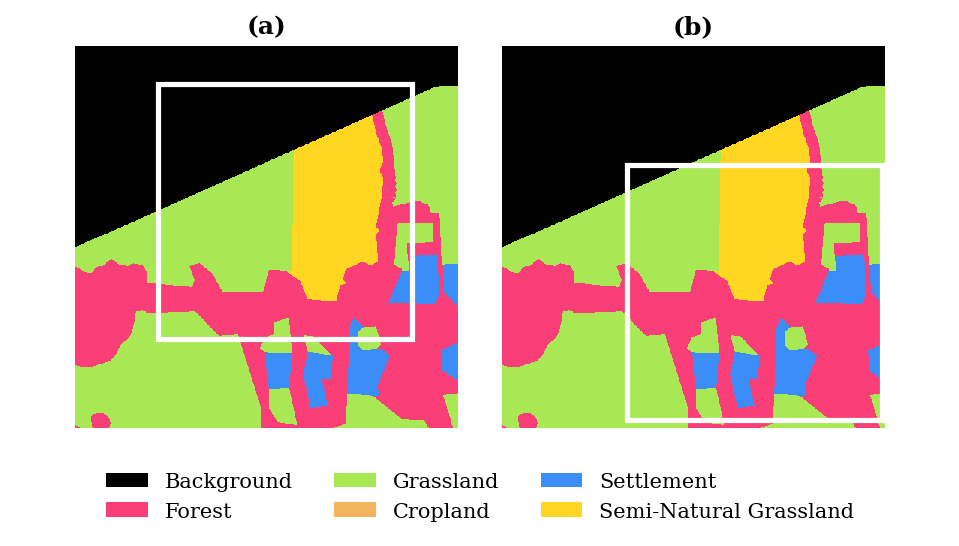

Saved: /home/lainey/Documents/Github/ClassImbalance/figures/fig7_minority_cropping_schematic.pdf


In [171]:
plot_fig7(mask_s, bbox_r, bbox_m, OUT_PDF)

In [152]:
def find_good_tile(max_tiles=200):
    """
    Find a tile where:
      - RANDOM crop (SmartCropV1) does NOT include minority classes (4/5)
      - MINORITY-aware crop (SmartCropV2) DOES include them
      - and the two crops are not identical (different bbox)
    """
    cand = sorted(MSK_DIR.glob("*.png"))  # deterministic order (no shuffle)

    for p in cand[:max_tiles]:
        m0 = np.array(Image.open(p))

        if not ((m0 == 4).any() or (m0 == 5).any()):
            continue

        H, W = m0.shape[:2]
        m = resize(
            m0,
            (int(H * SCALE), int(W * SCALE)),
            order=0,
            preserve_range=True,
            anti_aliasing=False,
        ).astype(m0.dtype)

        crop_r, bbox_r = smartcrop_v1_bbox(
            m,
            crop_size=CROP_SIZE,
            max_ratio=MAX_RATIO,
            ignore_index=IGNORE_INDEX,
            seed=SEED_RANDOM,
        )

        crop_m, bbox_m = smartcrop_v2_bbox(
            m,
            crop_size=CROP_SIZE,
            num_classes=NUM_CLASSES,
            class_interest=CLASS_INTEREST,
            class_ratio=CLASS_RATIO,
            max_ratio=MAX_RATIO,
            ignore_index=IGNORE_INDEX,
            seed=SEED_MINORITY,
        )

        rand_has = (crop_r == 4).any() or (crop_r == 5).any()
        min_has  = (crop_m == 4).any() or (crop_m == 5).any()

        if (not rand_has) and min_has and (bbox_r != bbox_m):
            return p, m, bbox_r, bbox_m

    return None


Found good tile: biodiversity_0002


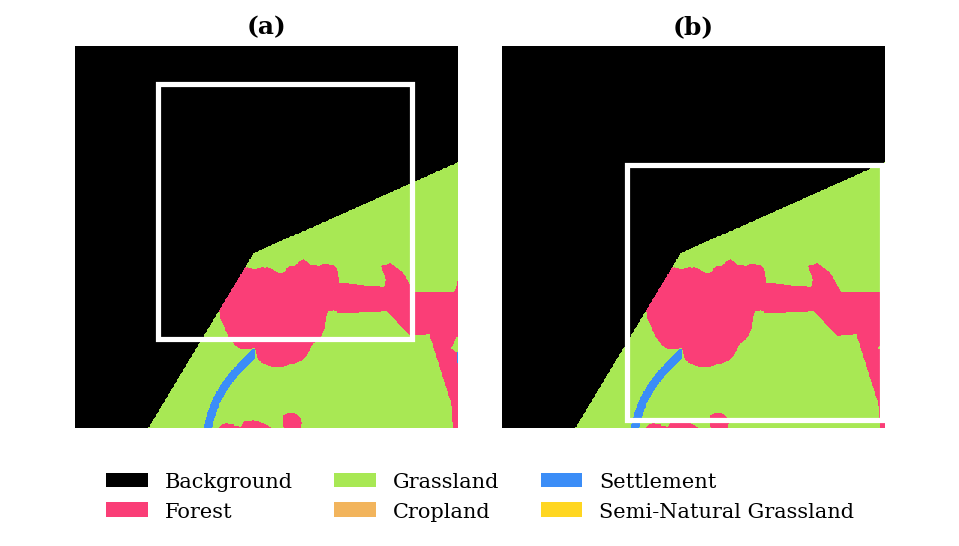

Saved: /home/lainey/Documents/Github/ClassImbalance/figures/fig7_minority_cropping_schematic.pdf
Saved: /home/lainey/Documents/Github/ClassImbalance/figures/fig7_minority_cropping_schematic.pdf


In [153]:
res = find_good_tile()

if res is None:
    print("Did not find a strong contrast tile quickly. Increase max_tiles or relax criteria.")
else:
    mask_path, mask_s, bbox_r, bbox_m = res
    print("Found good tile:", mask_path.stem)

    plot_fig7(mask_s, bbox_r, bbox_m, OUT_PDF)
    print("Saved:", OUT_PDF)
